In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from my_data.testCases_v4a import *
from my_data.dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward
import time
import scipy
from PIL import Image
from scipy import ndimage
import imageio
import scipy.misc
from my_data.dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [8]:
def initialize_parameters_deep(layer_dims):    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers + 1 in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
    return parameters

In [9]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    
    return Z, cache

In [10]:
def linear_activation_forward(A_prev, W, b, activation):
    # linear-cache contains Aprev, W, b
    # activation-cache contains Z
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [11]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network

    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], activation="relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], activation="sigmoid")
    caches.append(cache)

            
    return AL, caches

In [12]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1/m)*(np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL),axis=1,keepdims=True))
    cost = np.squeeze(cost)      # To make sure the cost's shape is what we expect (e.g. this turns [[17]] into 17).
    return cost

In [13]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [14]:
def linear_activation_backward(dA, cache, activation):
    # linear-cache contains Aprev, W, b
    # activation-cache contains Z
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)

    return dA_prev, dW, db

In [15]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)],current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [16]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    return parameters

In [18]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


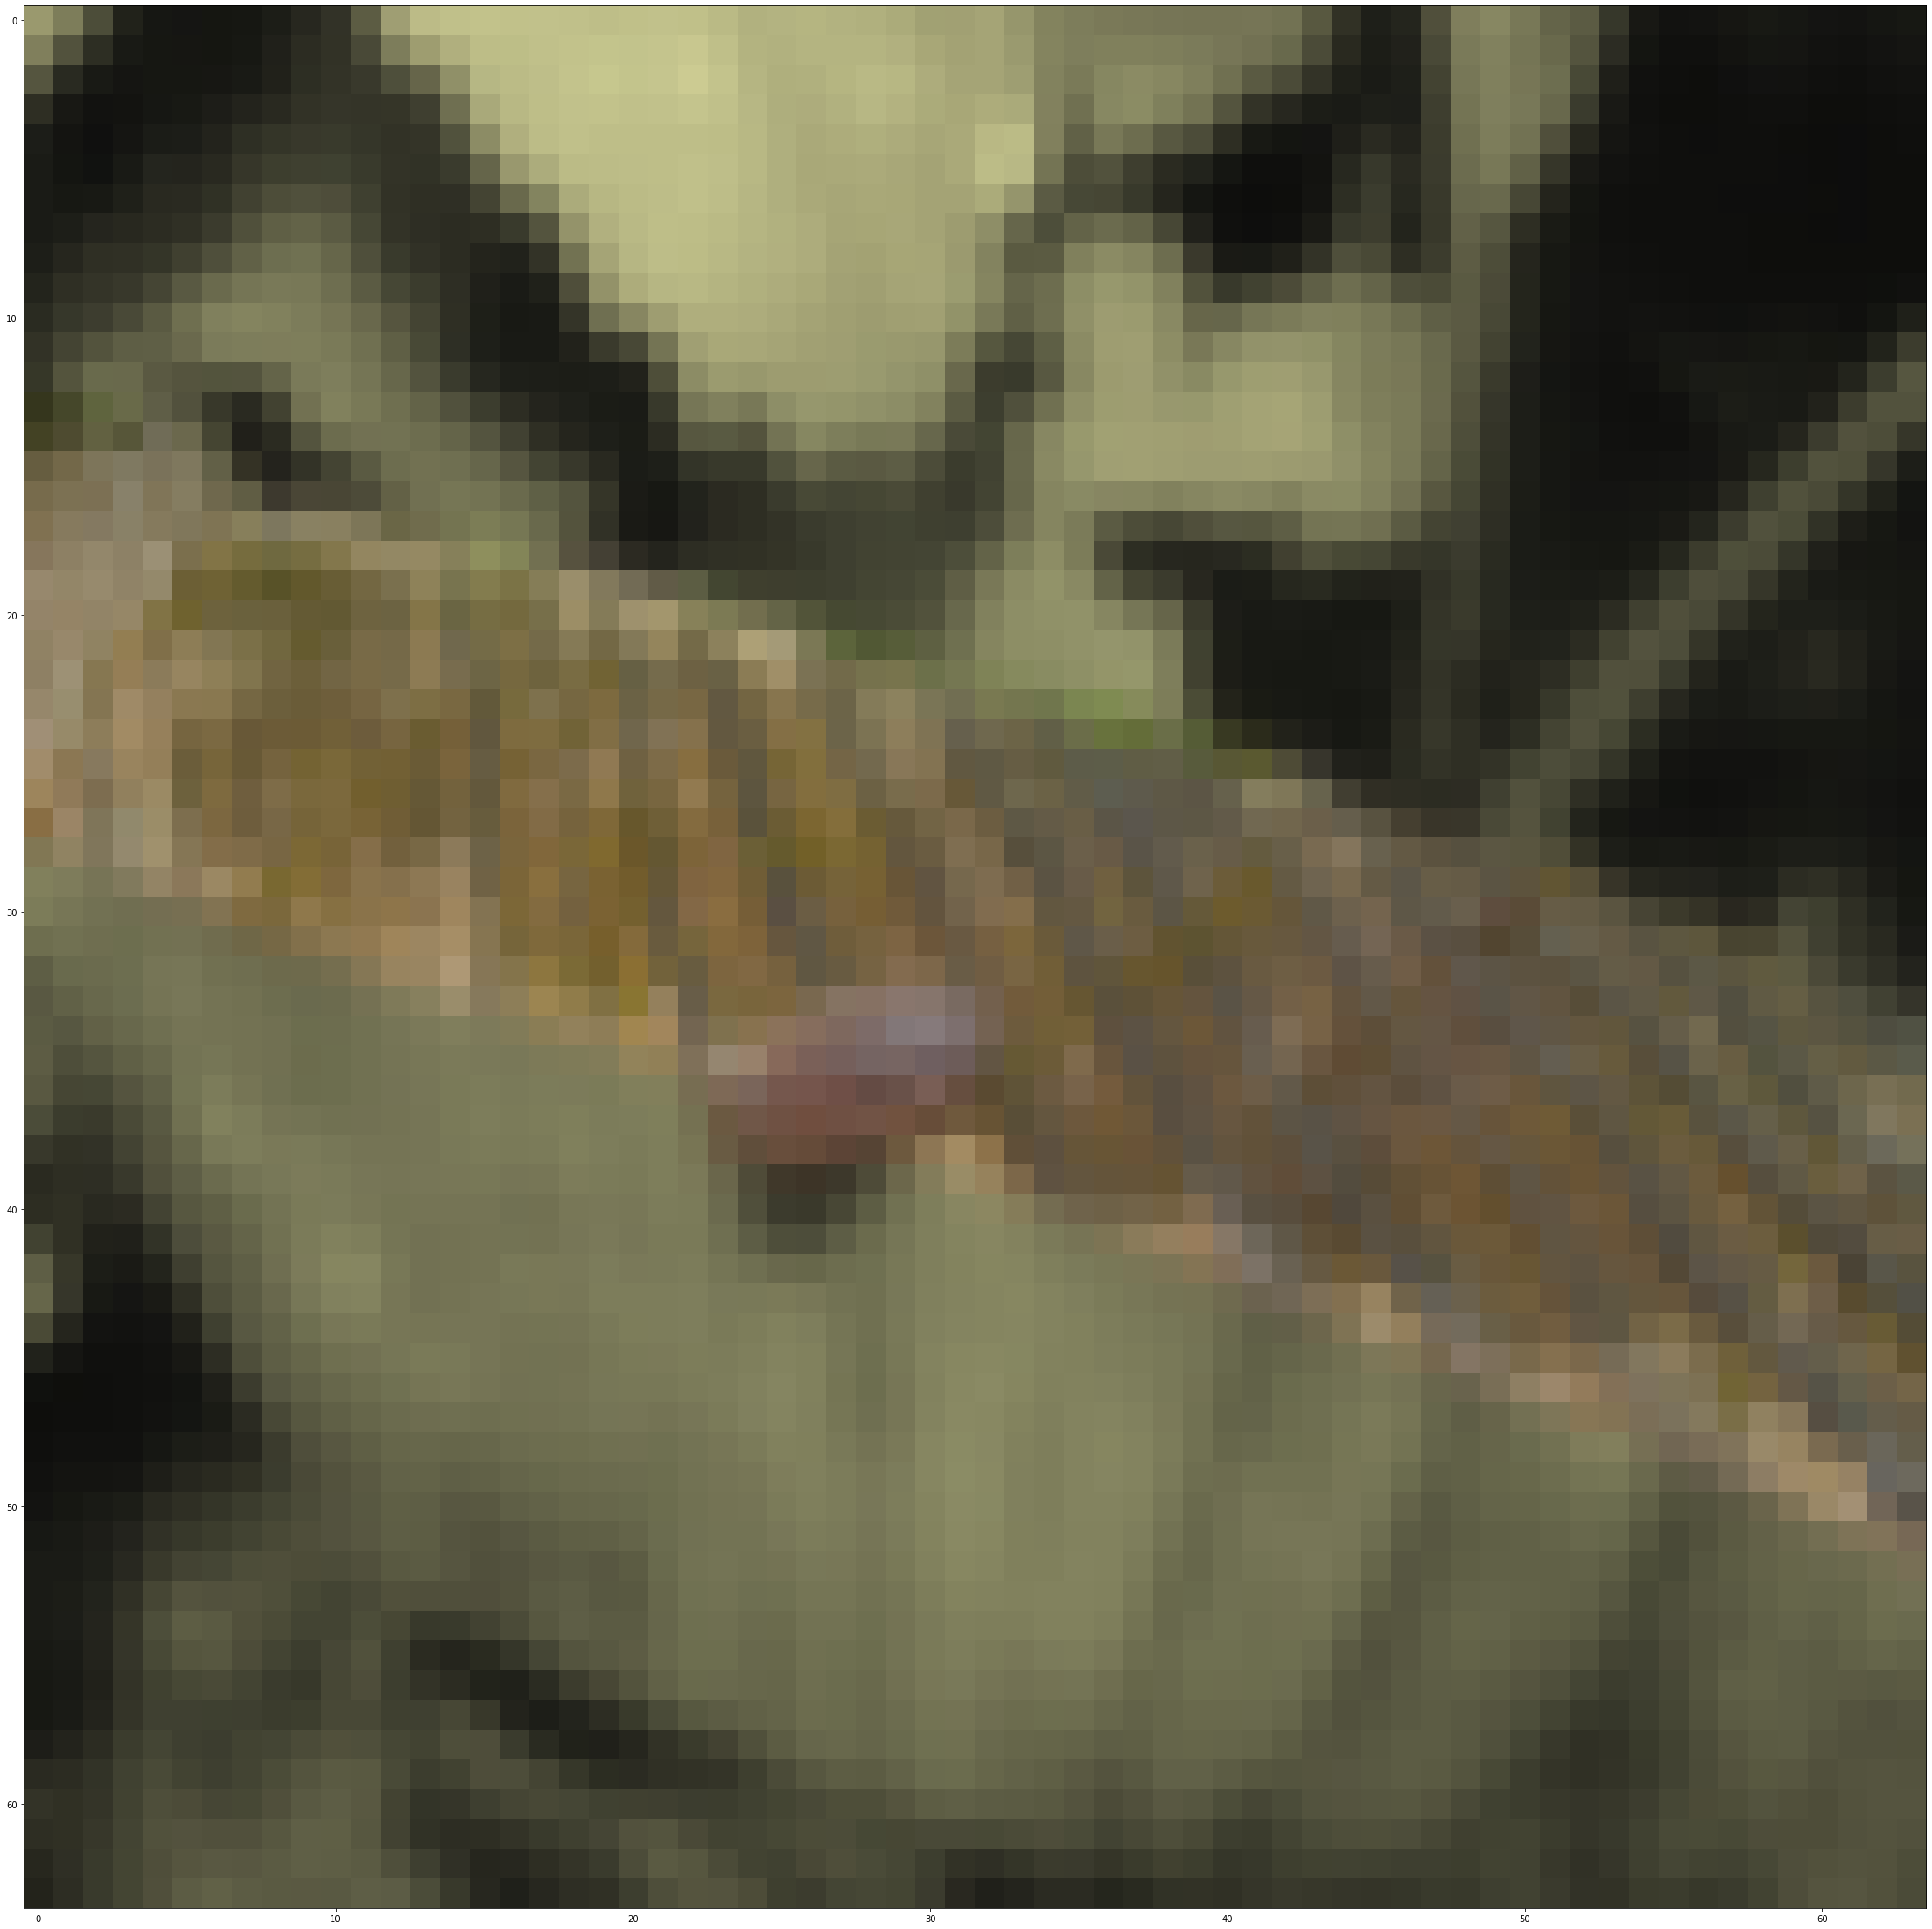

In [48]:
# Example of a picture
index = 12
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [21]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [22]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [23]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [40]:

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009

    np.random.seed(1)
    costs = []                         # keep track of cost

    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [41]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047


KeyboardInterrupt: 

In [26]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [27]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


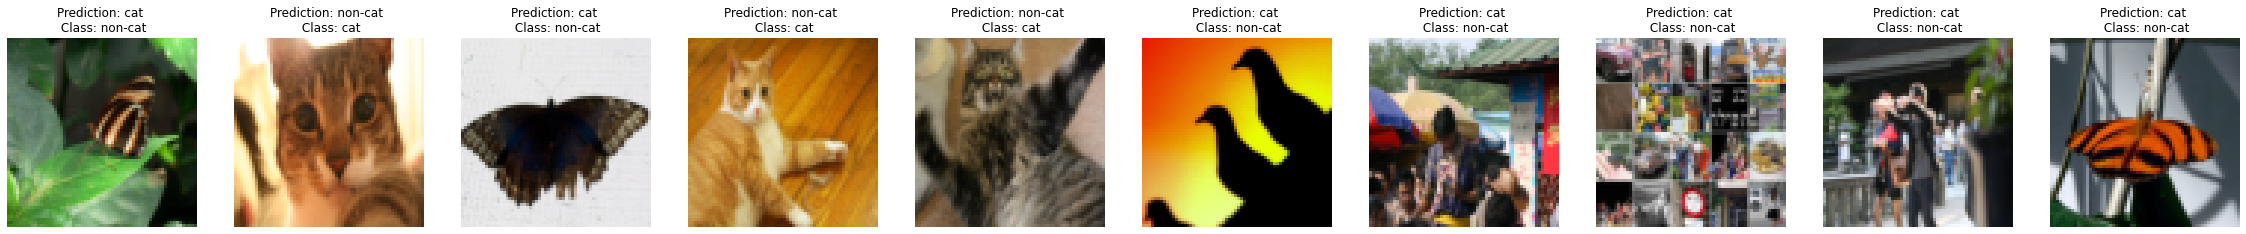

In [28]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


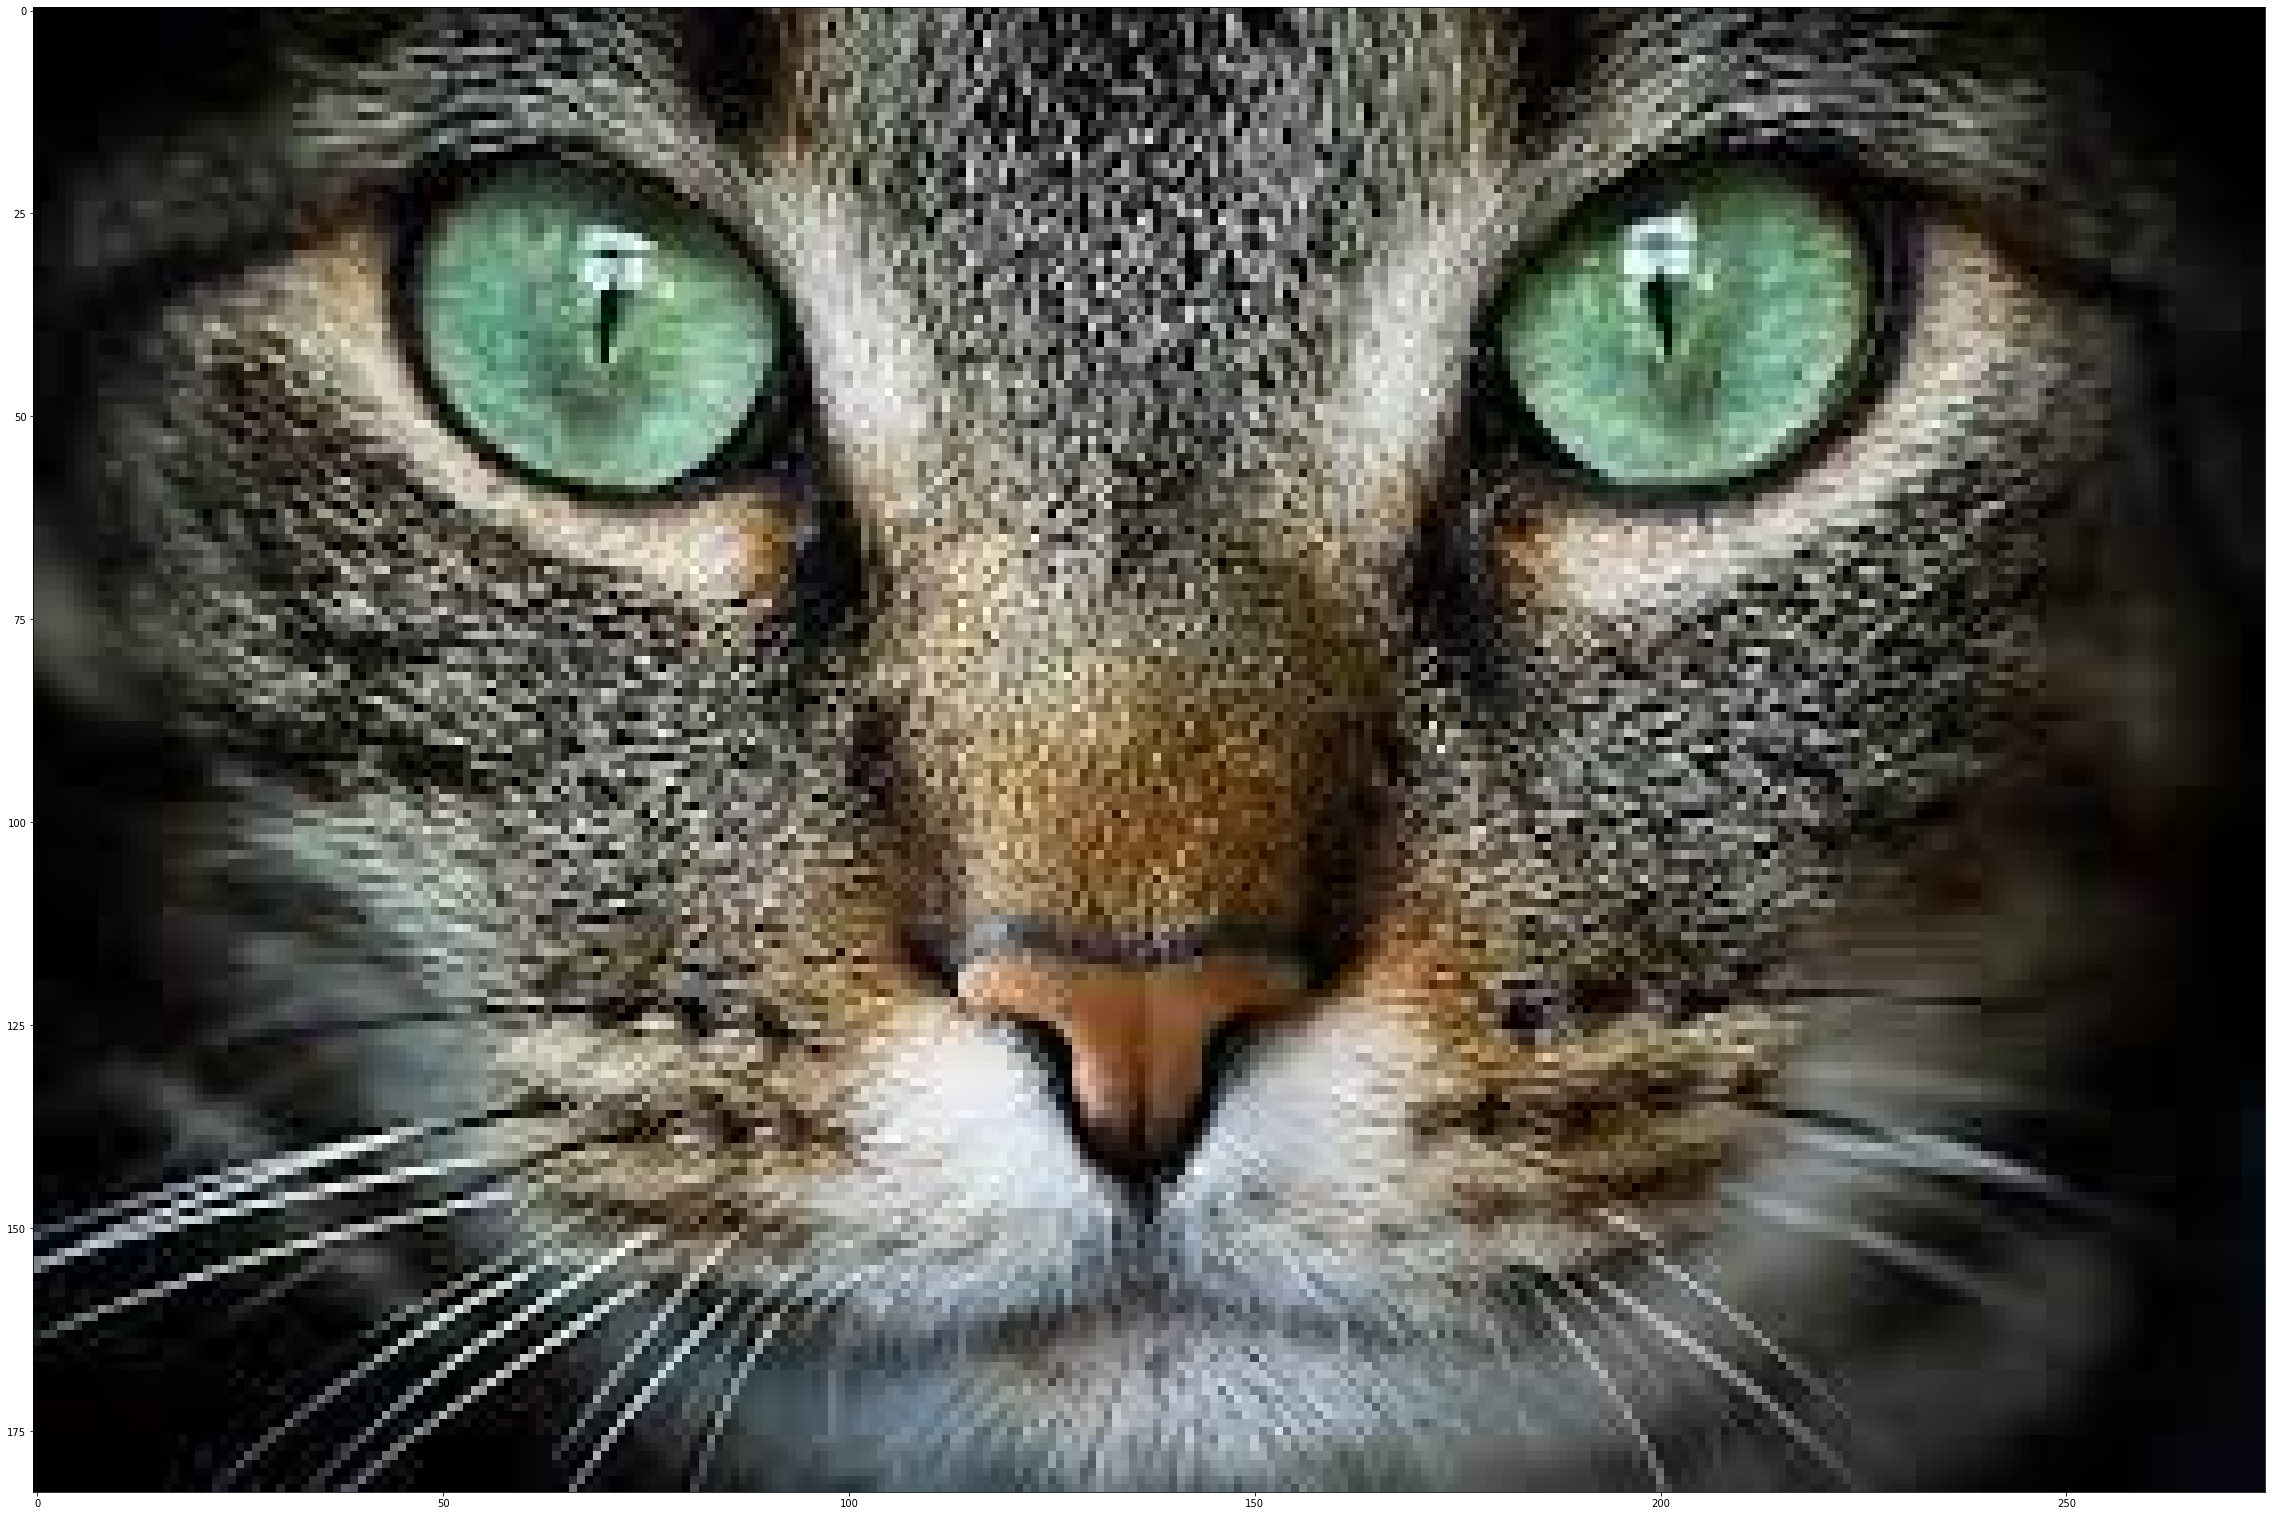

In [45]:
## START CODE HERE ##
my_image = "cat8.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "my_data/" + my_image
image = np.array(Image.open(fname))
from skimage.transform import resize
my_image = resize(image, output_shape=(num_px,num_px)).reshape(( num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")